A continuación se muestra un esquema, a modo de resumen, de los cinco pasos que realiza el script


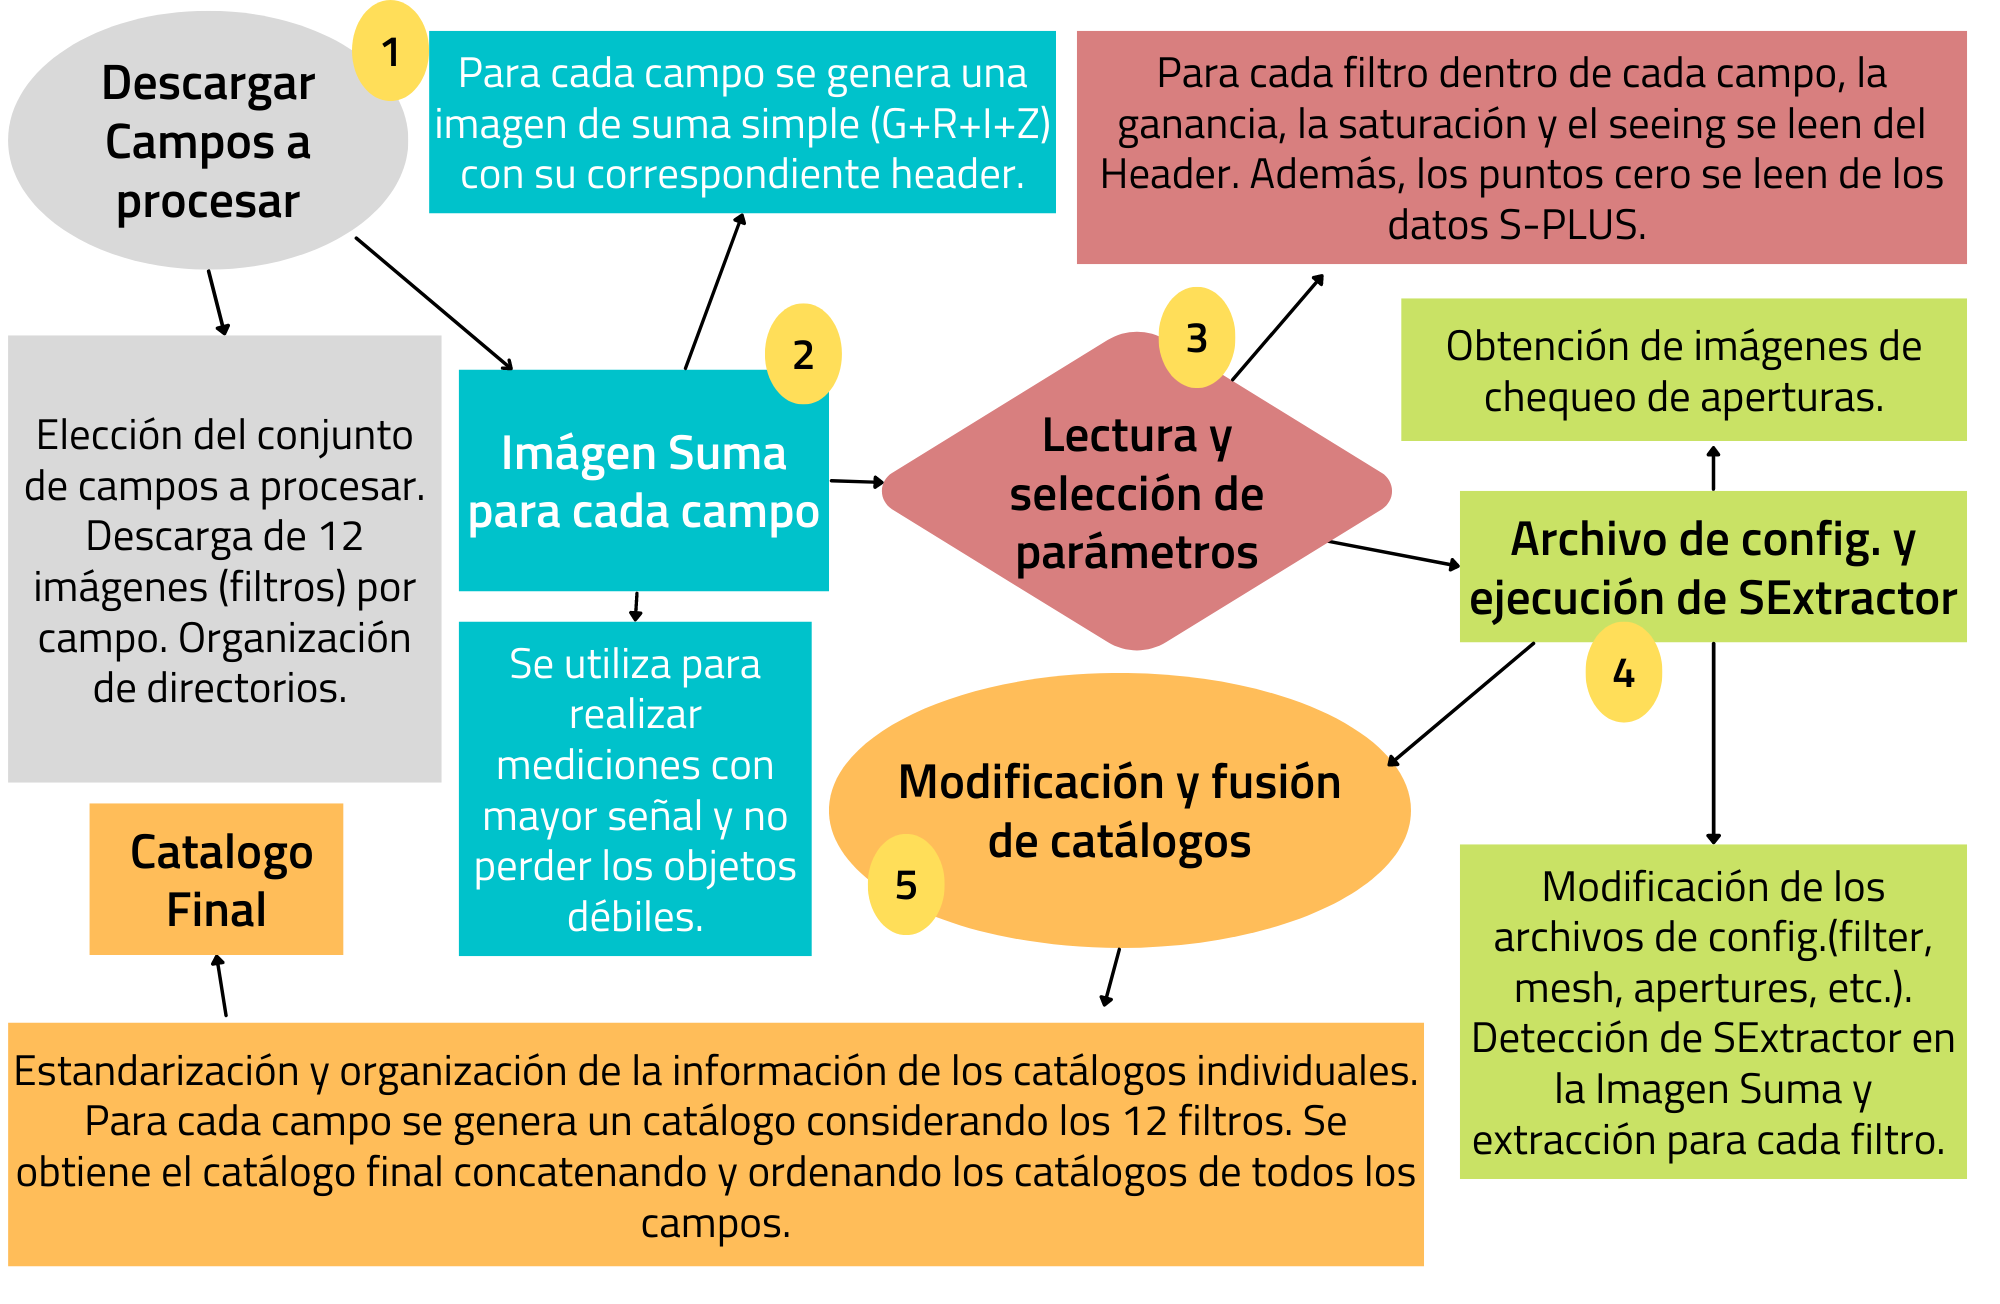





Importamos los paquetes necesarios para todo el código.

In [ ]:
import splusdata
from astropy.io import fits
import os
import getpass
import shutil
import subprocess
import csv
import re
import pandas as pd
from astropy.table import Table
from functools import reduce

## ***PASO 1: Descargar campos a utilizar***

El usuario deberá loguearse en splus.cloud

In [ ]:
username = input(prompt="Login: ")
#password = getpass("Password: ")
password = input("Password: ")
conn = splusdata.connect(username, password)

Se eligen explícitamente en formato de lista los campos S-PLUS que se desean descargar, un ejemplo de cómo se nomenclan los campos SPLUS es: "SPLUS-s24s31", además se indica los filtro a utilizar. 

In [ ]:
lista_campos = ("SPLUS-s24s31","SPLUS-s24s32")
lista_filtros = ("F378", "F395", "F410", "F430", "F515", "F660", "F861", "U", "G", "R", "I", "Z")

Se crean una carpeta “Campos”. Para cada campo se crea una subcarpeta dentro de “Campos” con el nombre del campo y dentro de esta última una llamada “Imagenes Originales”, en la cuál se descargan 12 imágenes, una por cada filtro.

Una vez obtenida una imagen, se revisa que el header sea el completo y no el breve. Luego de la revisión, se guarda la imagen correspondiente a un filtro y se prosigue con el  siguiente. Al haber culminado de descargar las 12 imágenes para un cierto campo, se pasa a realizar el mismo proceso para el siguiente campo.

In [ ]:
for campo in lista_campos:
    print("Procesando:", campo)
    os.makedirs(f'Campos/{campo}/Imagenes_originales/', exist_ok=True)
    for filtro in lista_filtros:
        print("Procesando:", campo, filtro)
        hdu = conn.get_field(campo, filtro)
        hdu.writeto(f"Campos/{campo}/Imagenes_originales/{campo}_{filtro}_swp.fits", overwrite=True)
        hdul1 = fits.open(f"Campos/{campo}/Imagenes_originales/{campo}_{filtro}_swp.fits")
        hdr2 = hdul1[1].header
        print(hdr2) # Aquí se revisa el header
        hdul1_data = fits.getdata(f"Campos/{campo}/Imagenes_originales/{campo}_{filtro}_swp.fits")
        fits.writeto(f"Campos/{campo}/Imagenes_originales/{campo}_{filtro}_swp.fits", data = hdul1_data, header = hdr2, overwrite = True)
        

## ***PASO 2: Imágen Suma***

En este paso para cada campo se crea una carpeta “Imagenes” en paralelo a “Imágenes Originales”, se copian las 12 imágenes originales descargadas a la nueva carpeta, esto se realiza para tener un respaldo. Para realizar esto se utilizan los paquetes “os” y “shutil”.

In [ ]:
for campo in lista_campos:
    print("Procesando:", campo)
    filtros_de_cada_campo = os.listdir(f'Campos/{campo}/Imagenes_originales')
    os.makedirs(f'Campos/{campo}/Imagenes/', exist_ok=True)
    for filtro in filtros_de_cada_campo:
        dir_entrada = f'Campos/{campo}/Imagenes_originales/{filtro}'
        shutil.copy(dir_entrada, f'Campos/{campo}/Imagenes/')


Luego para cada campo se lee la data (arreglo de pixeles) de las imágenes correspondientes a los filtros: “G”, “R”, “I” y “Z”. Como tenemos 4 arreglos podemos sumarlos y así generar una imagen suma. La suma es una suma simple no ponderada, es decir, los 4 filtros tienen el mismo peso. Mismo procedimiento que realiza la colaboración S-PLUS.

Al filtro “I” además de leerle la data se le lee el header, se lo duplica y se le modifican los siguientes parámetros: FILTER y FILENAME.

Este Header modificado es asignado como header de la imagen suma. La cual es guardada en paralelo al resto de los 12 filtro, es decir, en la carpeta “Imagenes”. Se realiza el mismo proceso para todos los restantes campos.

La imagen suma generada será utilizada para correr SExtractor, cumpliendo la función de se la imagen de medición, osea, la referencia de donde se harán las extracciones para cada filtro. La principal motivación de construir una imagen suma es poder aumentar la señal e intentar no perder objetos débiles al momento de la medición.


In [ ]:
for campo in lista_campos:
    print("Generando imagen suma del campo:", campo)
    img_i = fits.getdata(f'Campos/{campo}/Imagenes/{campo}_I_swp.fits')
    img_r = fits.getdata(f'Campos/{campo}/Imagenes/{campo}_R_swp.fits')
    img_g = fits.getdata(f'Campos/{campo}/Imagenes/{campo}_G_swp.fits')
    img_z = fits.getdata(f'Campos/{campo}/Imagenes/{campo}_Z_swp.fits') 
    suma_filtros = img_i + img_r + img_g + img_z # imagen compuesta de la suma de los filtros
    hdul1 = fits.open(f'Campos/{campo}/Imagenes/{campo}_I_swp.fits')
    hdr2 = hdul1[0].header # lectura del header del filtro I 
    hdr2.set('FILTER', 'G+R+I+Z') # cambio del filtro en el header de la imagen compuesta
    hdr2.set('FILENAME', f'Campos/{campo}/Imagenes/{campo}_suma.fits') # cambio del nombre de archivo en la imagen compuesta
    print("SE IMPRIMIRA EL HEADER", hdr2)
    fits.writeto(f'Campos/{campo}/Imagenes/{campo}_suma.fits', data = suma_filtros, header = hdr2, overwrite = True) # guardado de la data más el header con todas las modificaciones


## ***PASO 3: Lectura y selección de parámetros***

Aquí, el código comienza recorriendo un campo por uno y dentro de cada uno de ellos construye un lista con las 12 imágenes de filtros y logra identificar y apartar a la imagen suma. Crea una carpeta “Catalogos/{run}” paralela a “Imagenes” e “Imagenes Originales”.

Se lee por completo una tabla con los puntos de cero (ZP) previamente descargada y proporcionada por splus.cloud. Esta tabla contiene un campo por cada fila, y en las columnas el ZP correspondiente a cada filtro.

Se empieza a recorrer, dentro de un campo fijo, un filtro por uno. Por un lado, se lee el nombre del filtro, se lo identifica, y se le asigna el respectivo valor de zeropoint vinculado con la tabla. Por otro lado, a dicho filtro se le sustraen del header los siguientes parámetros:

SATURATE , GAIN y SEEING_FWHM

Esto se realiza con la intención de hacer la medición de SExtractor bajo los valores, de dichos parámetros, con los que fue tomada la imagen. Cabe mencionar, que los 3 parámetros varían según el filtro aún siendo imágenes del mismo campo. 

El presente paso y el siguiente estan dentro de la misma celda. Comparten ejecución.

## ***PASO 4: Archivos de configuración y ejecuciones de SExtractor***

En este paso, primero que nada se elige el archivo de configuración con el que se realizarán las ejecuciones de SExtractor. Los archivos de configuración incluyen información sobre los parámetros que se desean que aparezcan en el catálogo de salida, información sobre parámetros para guiar la detección y extracción, información sobre la imagen (fotometría y separación estrella/galaxia), información para realizar la estimación del background y por último sobre las imágenes de chequeo.

Una vez elegido el archivo de configuración y recordando que se está recorriendo filtro por filtro dentro de un cierto campo y que por cada campo se tiene identificado a la imagen suma. Se genera una dirección dual, directorio que incluye tanto a la imagen de detección como a la de medición. La de detección será la imagen suma y será la misma para todos los filtros del campo, mientras que la imagen de medición irá variando filtro a filtro. Para ejecutar SExtractor desde Python se utilizo el paquete “subprocess”, el cuál interactúa con una terminal bash para justamente correr SExtractor. 

Se elige el nombre con el que se identificará la corrida, el cúal es asignado a "run".

La salida de esta ejecución genera un catálogo por cada filtro que es guardado en  “/Campos/{campo}/Catalogos/{run}/cat_{filtro}. Es decir, en esta instancia, por campo habrá 12 catálogos.

Además en estas PASO se obtienen las imágenes de chequeo, CHECK_IMAGES. Para ello simplemente se realiza una sola ejecución de SExtractor en modo simple, es decir, se detecta y se mide sobre la misma imagen. Y la imagen utilizada para realizar dicho proceso, es la imágen suma correspondiente a cada campo. 

Donde luego de la ejecución de SExtractor, se crea un directorio “Imagenes_check” en paralelo a la carpetas “Campos” y dentro de es carpeta, mueve la imagen de chequeo correspondiente al campo a una subcarpeta “Imagenes_check/{run}”. Por lo tanto, las imágenes de chequeo de todos los campos quedan guardadas diferenciadas por {run}.



In [ ]:
#puntos_cero = open('Archivos_de_Configuracion/iDR4_zero-points.csv', 'r', encoding = "utf8")
#puntos_cero_reader = csv.reader(puntos_cero, delimiter = ',')
#header = next(puntos_cero) 
archivo_configuracion = input(prompt="Ingrese el nombre del archivo de configuración a utilizar: ")
dir_entrada_configuracion = f'Archivos_de_Configuracion/{archivo_configuracion}'
run = input(prompt="Ingrese el nombre con el que identificará las ejecuciones: ")
for campo in lista_campos:
    filtros_de_cada_campo_aux = os.listdir(f'Campos/{campo}/Imagenes')
    filtros_de_cada_campo = list(filter(lambda filtro: (not filtro.count('.fz')) and (not filtro.count('suma')), filtros_de_cada_campo_aux)) 
    lista_filtro_suma = list(filter(lambda filtro: filtro.count('suma'), filtros_de_cada_campo_aux))
    filtro_suma = lista_filtro_suma[0]
    dir_entrada_suma = f'Campos/{campo}/Imagenes/{filtro_suma}'
    os.makedirs(f"Campos/{campo}/Catalogos/{run}/", exist_ok=True)            
    print("Procesando", campo)
    puntos_cero = open('Archivos_de_Configuracion//iDR4_zero-points.csv', 'r', encoding = "utf8")
    puntos_cero_reader = csv.reader(puntos_cero, delimiter = ',')
    header = next(puntos_cero)
    for row in puntos_cero_reader:
            if row[0] == campo:
                for filtro in filtros_de_cada_campo:
                    dir_salida = f'Campos/{campo}/Catalogos/{run}/cat_{filtro}'
                    isExist = os.path.exists(dir_salida)
                    if not isExist:
                        if filtro.count('U_swp.fits'):
                            zeropoint = row[3]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F378_swp.fits'):
                            zeropoint = row[4]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F395_swp.fits'):
                            zeropoint = row[5]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F410_swp.fits'):
                            zeropoint = row[6]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F430_swp.fits'):
                            zeropoint = row[7]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('G_swp.fits'):
                            zeropoint = row[8]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F515_swp.fits'):
                            zeropoint = row[9]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('R_swp.fits'):
                            zeropoint = row[10]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F660_swp.fits'):
                            zeropoint = row[11]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('I_swp.fits'):
                            zeropoint = row[12]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('F861_swp.fits'):
                            zeropoint = row[13]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        elif filtro.count('Z_swp.fits'):
                            zeropoint = row[14]
                            print("Campo:", campo, "Filtro:", filtro, "Punto de cero:", zeropoint)
                        dir_entrada = f'Campos/{campo}/Imagenes/{filtro}'
                        dir_salida = f'Campos/{campo}/Catalogos/{run}/cat_{filtro}' 
                        hdul = fits.open(dir_entrada)
                        hdr = hdul[0].header
                        SATURATE = hdr['SATURATE']
                        GAIN = hdr['GAIN']   
                        SEEING_FWHM = hdr['HIERARCH OAJ PRO FWHMSEXT']
                        dir_dual = f'"Campos/{campo}/Imagenes/{filtro_suma}","Campos/{campo}/Imagenes/{filtro}"'
                        print("Generando catalogo", filtro)
                        subprocess.run(["sextractor", dir_dual, "-c", f"{dir_entrada_configuracion}", f"-CATALOG_NAME {dir_salida}", f"-GAIN {GAIN}", f"-SEEING_FWHM {SEEING_FWHM}", f"-SATUR_LEVEL {SATURATE}", f"-MAG_ZEROPOINT {zeropoint}"])
                        os.makedirs(f"Campos/{campo}/Imagenes_check/", exist_ok=True)
                        dir_salida_check_aux = f'{campo}_{run}.fits'
                        dir_check = re.sub("SPLUS-","",dir_salida_check_aux)
                        print("GENERANDO IMAGEN CHECK DE:", dir_check)
                        subprocess.run(["sextractor", dir_entrada_suma, "-c", f"{dir_entrada_configuracion}", "-CATALOG_NAME", "../cat_2.fits", "-CHECKIMAGE_TYPE", "APERTURES", "-CHECKIMAGE_NAME", f"../{dir_check}"])
                        os.makedirs(f"../Imagenes_check/{run}/", exist_ok=True)
                        shutil.move(f"../{dir_check}", f"../Imagenes_check/{run}/")

## ***PASO 5: Modificación y fusión de catálogos***

En esta instancia se realiza el proceso de estandarización, union y fusión de los catálogos. Se comienza nuevamente recorriendo campo por campo, filtro por filtro. Se crea un directorio dentro de la carpeta “/Campos/{campo}/Catalogos/” llamado “Catalogos_modificados” donde se copian los 12 catalogos correspondientes a sus respectivos filtros que fueron generados en el PASO 4 y que se encuentran en “/Campos/{campo}/Catalogos/{run}/”.

A estas copias de los catálogos se le realizarán las siguientes modificaciones. Por un lado, se despliegan todas las columnas que sean arreglos. Este es el caso de: las MAG_APER, sus errores, FLUX_APER, sus errores y también de los FLUX_RADIUS.

Luego a esa primera modificación se le suma una modificación en el nombre de ciertas columnas. Esto se realiza buscando, por un lado, estandarizar los nombres para que coincidan con los catalogos S-PLUS y, por otro lado, para agregarles el nombre del filtro explícitamente en las columnas que difieren entre catálogos de distintos filtros dentro del mismo campo. 

Donde por primera vez aquí se utiliza el paquete “pandas” para leer y modificar el catálogo como un DataFrame. Nuevamente este catálogo modificado sobrescribe al anterior.

In [ ]:
for campo in lista_campos:
    print("Procesando:",campo)
    lista_catalogos_internos_aux = os.listdir(f'Campos/{campo}/Catalogos/{run}')
    lista_catalogos_internos = list(map(lambda cat: re.sub(".fits","",cat), lista_catalogos_internos_aux))
    os.makedirs(f"Campos/{campo}/Catalogos/Catalogos_modificados/{run}/", exist_ok=True)
    for catalogo in lista_catalogos_internos:
        print("Generando:",catalogo)
        if catalogo.count('U_swp'):
            filtro = "U"
        elif catalogo.count('F378_swp'):
            filtro = "F378"
        elif catalogo.count('F395_swp'):
            filtro = "F395"
        elif catalogo.count('F410_swp'):
            filtro = "F410"
        elif catalogo.count('F430_swp'):
            filtro = "F430"
        elif catalogo.count('G_swp'):
            filtro = "G"
        elif catalogo.count('F515_swp'):
            filtro = "F515"
        elif catalogo.count('R_swp'):
            filtro = "R"
        elif catalogo.count('F660_swp'):
            filtro = "F660"
        elif catalogo.count('I_swp'):
            filtro = "I"
        elif catalogo.count('F861_swp'):
            filtro = "F861"
        elif catalogo.count('Z_swp'):
            filtro = "Z" 
        subprocess.run(["stilts", "tcopy", f"Campos/{campo}/Catalogos/{run}/{catalogo}.fits", f"Campos/{campo}/Catalogos/Catalogos_modificados/{run}/{catalogo}.fits", "ifmt=fits", "ofmt=fits"])
        dir_1 = f"Campos/{campo}/Catalogos/Catalogos_modificados/{run}/{catalogo}.fits"
        subprocess.run(["stilts", "tpipe", f'in={dir_1}',"cmd= explodeall", f'out={dir_1}'])
        dat = Table.read(f"Campos/{campo}/Catalogos/Catalogos_modificados/{run}/{catalogo}.fits")
        df = dat.to_pandas()
        df.rename(columns={'ALPHA_J2000':'RA', 'DELTA_J2000':'DEC', 'FLUX_AUTO':f'FLUX_AUTO_{filtro}','FLUXERR_AUTO':f'FLUXERR_AUTO_{filtro}','MAG_AUTO':f'{filtro}_AUTO','MAGERR_AUTO':f'e_{filtro}_AUTO','FLUX_ISO':f'FLUX_ISO_{filtro}','FLUXERR_ISO':f'FLUXERR_ISO_{filtro}','MAG_ISO':f'{filtro}_ISO','MAGERR_ISO':f'e_{filtro}_ISO','FLUX_PETRO':f'FLUX_PETRO_{filtro}','FLUXERR_PETRO':f'FLUXERR_PETRO_{filtro}','MAG_PETRO':f'{filtro}_PETRO','MAGERR_PETRO':f'e_{filtro}_PETRO','MAG_APER_1':f'{filtro}_APER_3','MAG_APER_2':f'{filtro}_APER_6','MAGERR_APER_1':f'e_{filtro}_APER_3','MAGERR_APER_2':f'e_{filtro}_APER_6','FLUX_APER_1':f'FLUX_APER_3_{filtro}','FLUX_APER_2':f'FLUX_APER_6_{filtro}','FLUXERR_APER_1':f'FLUXERR_APER_3_{filtro}','FLUXERR_APER_2':f'FLUXERR_APER_6_{filtro}','FLAGS':f'FLAGS_{filtro}', 'FWHM_IMAGE':f'FWHM_IMAGE_{filtro}', 'FWHM_WORLD':f'FWHM_WORLD_{filtro}', 'ISOAREA_IMAGE':f'ISOAREA_IMAGE_{filtro}', 'ISOAREA_WORLD':f'ISOAREA_WORLD_{filtro}', 'KRON_RADIUS':f'KRON_RADIUS_{filtro}', 'PETRO_RADIUS':f'PETRO_RADIUS_{filtro}', 'FLUX_RADIUS_1':f'FLUX_RADIUS_20_{filtro}', 'FLUX_RADIUS_2':f'FLUX_RADIUS_50_{filtro}', 'FLUX_RADIUS_3':f'FLUX_RADIUS_70_{filtro}', 'FLUX_RADIUS_4':f'FLUX_RADIUS_90_{filtro}', 'FLUX_MAX':f'FLUX_MAX_{filtro}', 'SNR_WIN':f'SNR_WIN_{filtro}', 'MU_THRESHOLD':f'MU_THRESHOLD_{filtro}', 'THRESHOLD':f'THRESHOLD_{filtro}', 'MU_MAX':f'MU_MAX_{filtro}', 'CLASS_STAR':f'CLASS_STAR_{filtro}', 'BACKGROUND':f'BACKGROUND_{filtro}'},inplace=True)
        t = Table.from_pandas(df)
        t.write(f"Campos/{campo}/Catalogos/Catalogos_modificados/{run}/{catalogo}.fits", overwrite=True)

Posterior a este proceso, se procede a juntar todos los catálogos modificados de un mismo campo en solo un catálogo por campo. Para ello, utilizando otra vez “pandas”, se crea una lista de los 12 DataFrames correspondientes a los 12 catálogos modificados a fusionar. Antes de hacer la fusión de uno los DataFrames se extrae la información de las primeras columnas, es decir, se separa la información común a todos los catalogos, es decir, la astrometría y geometría.

Luego sobre la lista de DataFrames se realiza la fusión, bajo un matcheo doble en RA y DEC. Se agregan como primeras columnas “ID” y “Filter”, se ordena según RA y se le da un formato específico a los nombres de los objetos en la columna ID. 

In [ ]:
for campo in lista_campos:
    print("Procesando:",campo)
    lista_catalogos_aux = os.listdir(f'Campos/{campo}/Catalogos/Catalogos_modificados/{run}')
    for catalogo in lista_catalogos_aux:
        if catalogo.count('U_swp'):
            filtro_U = catalogo
        elif catalogo.count('F378_swp'):
            filtro_F378 = catalogo
        elif catalogo.count('F395_swp'):
            filtro_F395 = catalogo
        elif catalogo.count('F410_swp'):
            filtro_F410 = catalogo
        elif catalogo.count('F430_swp'):
            filtro_F430 = catalogo
        elif catalogo.count('G_swp'):
            filtro_G = catalogo
        elif catalogo.count('F515_swp'):
            filtro_F515 = catalogo
        elif catalogo.count('R_swp'):
            filtro_R = catalogo
        elif catalogo.count('F660_swp'):
            filtro_F660 = catalogo
        elif catalogo.count('I_swp'):
            filtro_I = catalogo
        elif catalogo.count('F861_swp'):
            filtro_F861 = catalogo
        elif catalogo.count('Z_swp'):
            filtro_Z = catalogo
    lista_catalogos = [filtro_U, filtro_F378, filtro_F395, filtro_F410, filtro_F430, filtro_G, filtro_F515, filtro_R, filtro_F660, filtro_I, filtro_F861, filtro_Z]
    data_frames = []
    df_1_aux = lista_catalogos[0]
    lector = Table.read(f'Campos/{campo}/Catalogos/Catalogos_modificados/{run}/{df_1_aux}')
    df_1 = lector.to_pandas()
    df_1.drop(df_1.iloc[:, 21:-1], inplace=True, axis='columns')
    data_frames.append(df_1)
    for catalogo in lista_catalogos:
        print("Procesando:", catalogo)         
        lector = Table.read(f'Campos/{campo}/Catalogos/Catalogos_modificados/{run}/{catalogo}')
        df = lector.to_pandas()
        df.drop(df.iloc[:, 0:1], inplace=True, axis='columns')
        df.drop(df.iloc[:, 2:20], inplace=True, axis='columns')
        data_frames.append(df)
    df_merged = reduce(lambda  left,right: pd.merge(left,right, on=['RA','DEC'], how='inner', copy=False), data_frames)
    lista_number = df_merged.NUMBER.to_list()
    df_merged.drop(columns ={'BACKGROUND_U_x'}, inplace=True)
    df_merged.drop(columns ={'NUMBER'}, inplace=True)
    df_merged.rename(columns={'BACKGROUND_U_y':'BACKGROUND_U'},inplace=True)
    df_merged = df_merged.sort_values('RA',ascending=True)
    df_merged.insert(0,"ID",lista_number,True)
    df_merged.insert(1, "Field", f"{campo}", allow_duplicates=False)
    df_merged = df_merged.sort_values('RA',ascending=True)
    for ID in range(len(df_merged.ID)+1):
        df_merged.ID = df_merged.ID.replace({ID: f"iDR4_FORNAX_RUN1_{campo}.{str(ID).rjust(5, '0')}"})
    t = Table.from_pandas(df_merged)
    t.write(f'Campos/{campo}/Catalogos/cat_{campo}_12_filtros_{run}.fits', overwrite=True)
    

El último paso antes de obtener el catálogs final, será leer los catálogos maestros de cada campo, trasformarlos en DataFrame e ir agregando uno por uno a una lista de DataFrames. Una vez, construida esta lista se procede a concatenar todos los catálogos de todos los campos, para lograr tener un único catalogo final estandarizado. A dicho catalogo se lo ordena por ID para que, conforme al formato dado para los ID, se ordene a los objetos por bloques de campos. Es decir, si se despliega el catalogo final, el mismo comenzara con todos los objetos correspondientes a un campo, luego a otro y así para/con todos los campos. Para ello,  las lineas que se ejecutan se muestran a continuación. Además, por una cuestión de memoria, bajo el mismo procedimiento se obtienen catálogos fraccionados. Muchas veces la memoria se llena al querer concatenar la información de todos los campos a la vez. 

In [ ]:
os.makedirs(f'Catalogos_finales',  exist_ok=True)
data_frames = []
lista_catalogos_a_concat = [] 
for campo in lista_campos:
    print("Procesando:", campo)
    archivos_campo_aux = os.listdir(f'Campos/{campo}/Catalogos')
    lista_catalogo_campo = list(filter(lambda filtro: filtro.count(f'_{run}.fits'), archivos_campo_aux))
    catalogo_campo_aux = lista_catalogo_campo[0]
    catalogo_campo = f'Campos/{campo}/Catalogos/' + catalogo_campo_aux
    print("Agregando:", catalogo_campo)
    lista_catalogos_a_concat.append(catalogo_campo)
    lector = Table.read(catalogo_campo)
    df = lector.to_pandas()
    data_frames.append(df)
data_frames_1 = data_frames[0:20]
data_frames_2 = data_frames[20:40]
data_frames_3 = data_frames[40:60]
data_frames_4 = data_frames[60:80]
data_frames_5 = data_frames[80:99]   

print("Realizando la concatenación_1")
df_concat = pd.concat(data_frames_1)
print("Paso la concatenación_1")
df_concat = df_concat.sort_values('ID',ascending=True)
t = Table.from_pandas(df_concat)
t.write(f'Catalogos_finales/Catalogos_explode/catalogo_final_{run}_1.fits', overwrite=True)

print("Realizando la concatenación_2")
df_concat = pd.concat(data_frames_2)
print("Paso la concatenación_2")
df_concat = df_concat.sort_values('ID',ascending=True)
t = Table.from_pandas(df_concat)
t.write(f'Catalogos_finales/Catalogos_explode/catalogo_final_{run}_2.fits', overwrite=True)

print("Realizando la concatenación_3")
df_concat = pd.concat(data_frames_3)
print("Paso la concatenación_3")
df_concat = df_concat.sort_values('ID',ascending=True)
t = Table.from_pandas(df_concat)
t.write(f'Catalogos_finales/Catalogos_explode/catalogo_final_{run}_3.fits', overwrite=True)
   
print("Realizando la concatenación_4")
df_concat = pd.concat(data_frames_4)
print("Paso la concatenación_4")
df_concat = df_concat.sort_values('ID',ascending=True)
t = Table.from_pandas(df_concat)
t.write(f'Catalogos_finales/Catalogos_explode/catalogo_final_{run}_4.fits', overwrite=True)
   
print("Realizando la concatenación_5")
df_concat = pd.concat(data_frames_5)
print("Paso la concatenación_5")
df_concat = df_concat.sort_values('ID',ascending=True)
t = Table.from_pandas(df_concat)
t.write(f'Catalogos_finales/Catalogos_explode/catalogo_final_{run}_5.fits', overwrite=True)

print("Realizando la concatenación_total")
df_concat = pd.concat(data_frames)
print("Paso la concatenación")
df_concat = df_concat.sort_values('ID',ascending=True)
t = Table.from_pandas(df_concat)
t.write(f'Catalogos_finales/catalogo_final_{run}.fits', overwrite=True)